In [1]:
#Block 1

#import necessary libraries
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from skimage.io import imread

Text(0.5, 1.0, 'row and columns convolved')

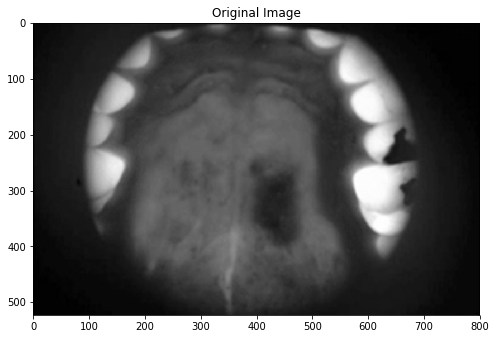

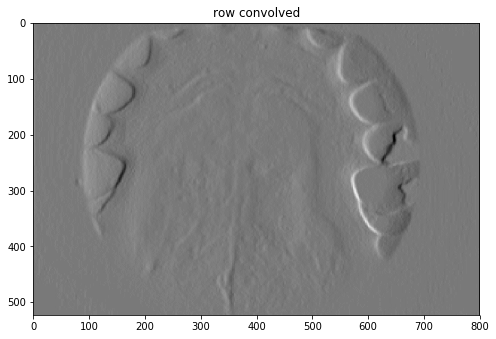

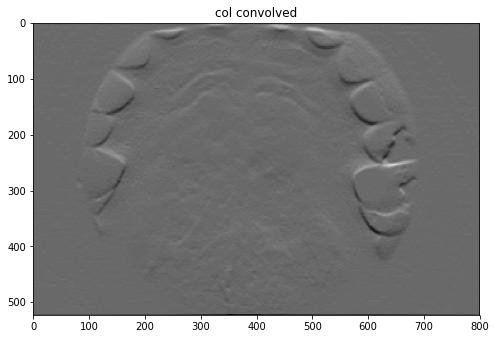

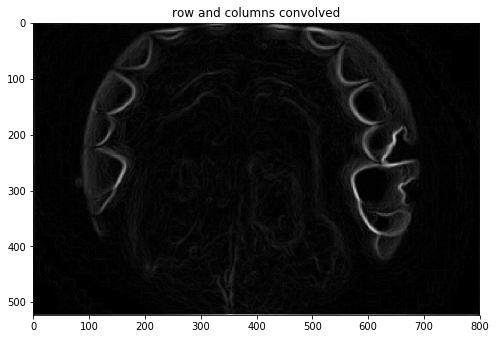

In [4]:
#Block 2
#Hard edge detection

#load the image
input_img = imread('oral0.png', 'gray')

#Filtering along the rows
edge_filter = np.array([1,0,-1])
total_rows,total_cols = input_img.shape

test_img_rows = np.zeros(input_img.shape) 
test_img_cols = np.zeros(input_img.shape)
test_img_rows_then_cols = np.zeros(input_img.shape)
test_img_rows_then_cols = np.zeros(input_img.shape)

index11 = 0
while index11 < total_rows:
    test_img_rows[index11,:] = signal.convolve(input_img[index11,:],edge_filter,'same')
    index11 += 1
    
plt.figure(figsize=(8,6))
plt.imshow(input_img,'gray')
plt.title('Original Image')

plt.figure(figsize = (8,6))
plt.imshow(test_img_rows,'gray')
plt.title('row convolved')


#Filtering along the columns

index12 = 0
while index12 < total_cols:
    test_img_cols[:,index12] = signal.convolve(input_img[:,index12],edge_filter,'same')
    index12 += 1

plt.figure(figsize = (8,6))
plt.imshow(test_img_cols,'gray')
plt.title('col convolved')


#Filtering along both. Note use of the distance formula


totality = np.zeros(input_img.shape)
for index13 in range(total_rows):
    for index14 in range(total_cols):
        totality[index13,index14] = ((test_img_rows[index13,index14])**2 + (test_img_cols[index13,index14])**2)**0.5
        #Place tracking for ML here. As we move alongside each pixel of the image, the value of
        #the element or the value of 3-4 series of neighboring pixels can be tracked in another matrix. As per the 
        #above written explanation, the edges can be easily determined by the values. In other words,
        # we can keep track of the edge data, and its location per image. We can then collect
        # this data from test images, then use those arrays as our test arrays with sci-kit.
        # Using the same edge detection, our algorithm will discern the edge data from new images
        # and compare it to the test-arrays. It will then automatically classify the new image into
        # a label category using decision boundaries we define (or perhaps boundaries learned from unsupervised methods)

plt.figure(figsize = (8,6))
plt.imshow(totality,'gray')
plt.title('row and columns convolved')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


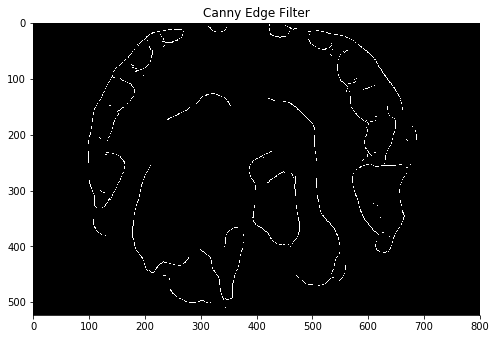

In [6]:
#Block 3
#Soft or Canny-edge detection

# import cv2

# img = cv2.imread('oral1.jpg',0)
# edges = cv2.Canny(img,100,200)

# plt.subplot(121),plt.imshow(img,cmap = 'gray')
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(edges,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

# plt.show()

#Alternatively, if you don't have openCV or if a Python-only solution is desired
#to make porting to another language easier/possible, use this:

import numpy as np
from scipy.ndimage.filters import convolve, gaussian_filter
from scipy.misc import imread, imshow

blur = 15
highThreshold = 5
lowThreshold = 0
 
def CannyEdgeDetector(im, blur=15, highThreshold=5, lowThreshold=0): #Adjust threshold percentages from 0 to 100%
    im = np.array(im, dtype=float) #Convert to float to prevent clipping values
    
 
    #Gaussian blur to reduce noise
    #gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    #im2 = gaussian_filter(im, blur)
    im2 = gaussian_filter(im, 10, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
 
    #Use sobel filters to get horizontal and vertical gradients
    im3h = convolve(im2,[[-1,0,1],[-2,0,2],[-1,0,1]]) 
    im3v = convolve(im2,[[1,2,1],[0,0,0],[-1,-2,-1]])
 
    #Get gradient and direction
    grad = np.power(np.power(im3h, 2.0) + np.power(im3v, 2.0), 0.5)
    theta = np.arctan2(im3v, im3h)
    thetaQ = (np.round(theta * (5.0 / np.pi)) + 5) % 5 #Quantize direction
 
    #Non-maximum suppression
    gradSup = grad.copy()
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            #Suppress pixels at the image edge
            if r == 0 or r == im.shape[0]-1 or c == 0 or c == im.shape[1] - 1:
                gradSup[r, c] = 0
                continue
            tq = thetaQ[r, c] % 4
 
            if tq == 0: #0 is E-W (horizontal)
                if grad[r, c] <= grad[r, c-1] or grad[r, c] <= grad[r, c+1]:
                    gradSup[r, c] = 0
            if tq == 1: #1 is NE-SW
                if grad[r, c] <= grad[r-1, c+1] or grad[r, c] <= grad[r+1, c-1]:
                    gradSup[r, c] = 0
            if tq == 2: #2 is N-S (vertical)
                if grad[r, c] <= grad[r-1, c] or grad[r, c] <= grad[r+1, c]:
                    gradSup[r, c] = 0
            if tq == 3: #3 is NW-SE
                if grad[r, c] <= grad[r-1, c-1] or grad[r, c] <= grad[r+1, c+1]:
                    gradSup[r, c] = 0
 
    #Double threshold
    strongEdges = (gradSup > highThreshold)
 
    #Strong has value 2, weak has value 1
    thresholdedEdges = np.array(strongEdges, dtype=np.uint8) + (gradSup > lowThreshold)
 
    #Tracing edges with hysteresis
    #Find weak edge pixels near strong edge pixels
    finalEdges = strongEdges.copy()
    currentPixels = []
    for r in range(1, im.shape[0]-1):
        for c in range(1, im.shape[1]-1):
            if thresholdedEdges[r, c] != 1:
                continue #Not a weak pixel
 
            #Get 3x3 patch
            localPatch = thresholdedEdges[r-1:r+2,c-1:c+2]
            patchMax = localPatch.max()
            if patchMax == 2:
                currentPixels.append((r, c))
                finalEdges[r, c] = 1
 
    #Extend strong edges based on current pixels
    while len(currentPixels) > 0:
        newPix = []
        for r, c in currentPixels:
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if dr == 0 and dc == 0: continue
                    r2 = r+dr
                    c2 = c+dc
                    if thresholdedEdges[r2, c2] == 1 and finalEdges[r2, c2] == 0:
                        #Copy this weak pixel to final result
                        newPix.append((r2, c2))
                        finalEdges[r2, c2] = 1
        currentPixels = newPix
 
    return finalEdges
 
if __name__=="__main__":
    im = imread("oral0.png", mode="L") #Open image, convert to greyscale
    finalEdges = CannyEdgeDetector(im)
    
    plt.figure(figsize = (8,6))
    plt.imshow(finalEdges,'gray')
    plt.title('Canny Edge Filter')

In [7]:
#Block 4
#Kernel Feature extraction

def convolve_2d(image,kernel):
    result = signal.convolve2d(image,kernel,'same')
    result[result < 0] = 0 #Keep values non-negative
    return result

#identify horizontal lines
horiz_kernel = np.array([[-2,-2,-2,-2,-2],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [-2,-2,-2,-2,-2]])

#identify vertical lines
vert_kernel = np.array([[-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2]])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


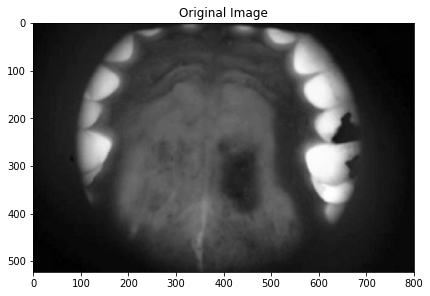

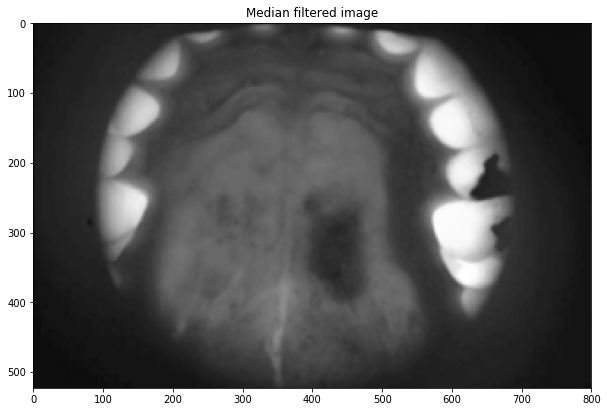

In [13]:
#Block 5
#Salt and Pepper Noise filtering

#one = imread('oral0.png')

#clean_image = imread('oral0.png', 'gray')
noisy_image = imread('oral0.png', 'gray')
plt.figure(figsize=(15,15))
plt.subplot(121)
#plt.imshow(clean_image,'gray')
plt.imshow(noisy_image,'gray')
plt.title('Original Image')

median_filter = signal.medfilt(noisy_image, kernel_size =5)
plt.figure(figsize=(10,10))
plt.title('Median filtered image')

plt.imshow(median_filter,'gray')